In [1]:
import CSV
using DataFrames
# using StatsBase
include("pred_funcs.jl")
using MLJ
# import MLJBase
import TableView.showtable
using Plots
import FileIO
import Statistics
using LazyArrays
import LinearAlgebra
using Flux

WebIO._IJuliaInit()

In [2]:
using Turing, Distributions

using MCMCChains, StatsPlots

using StatsFuns: logistic

using Random
Random.seed!(0);

using StatsBase
import MLJBase

In [3]:
MissingImputator = @load MissingImputator pkg="BetaML" verbosity=0
XGBoostClassifier = @load XGBoostClassifier verbosity=0  # loads code defining a model type
LogisticClassifier = @load LogisticClassifier pkg="MLJLinearModels" verbosity=0;  # loads code defining a model type
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier verbosity=0;  # loads code defining a model type
EvoTreeClassifier = @load EvoTreeClassifier verbosity=0
GradientBoostingClassifier = @load GradientBoostingClassifier verbosity=0
EvoTreeGaussian = @load EvoTreeGaussian verbosity=0
SVC = @load SVC verbosity=0
NeuralNetworkClassifier = @load NeuralNetworkClassifier

import MLJFlux ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/alexpanchot/.julia/packages/MLJModels/4sRmw/src/loading.jl:168


MLJFlux.NeuralNetworkClassifier

In [4]:
# run(`unzip data.zip`)
# run(`rm data_full.jld2`)

In [5]:
sample_key2, xold, yold = FileIO.load("data_full.jld2","sample_key","x" ,"y");
xold.col1=collect(1:nrow(xold));
println(nrow(xold))
# filter!(x->x.ALT_I>0.5 || x.REF_I>0.5,xold) # indel
# filter!(x->x.ALT_I<0.5 && x.REF_I<0.5,xold) # SNV
println(nrow(xold))
# filter!(x->x.training>0.5,xold)
# select!(xold,Not("training"));
println(nrow(xold))
filter!(x->!ismissing(x.dust_score_Vardict),xold);
println(nrow(xold))

2110529
2110529
2110529
526074


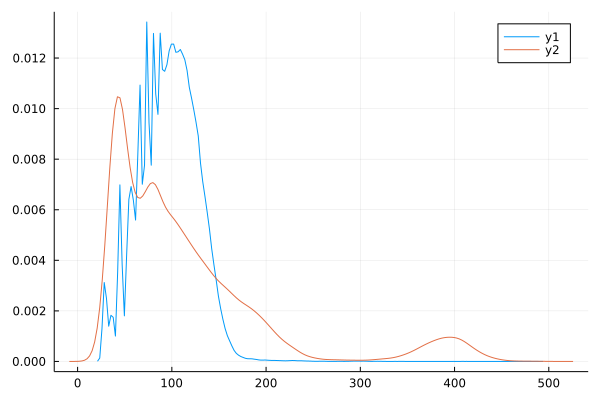


signal (15): Terminated: 15
in expression starting at /Users/alexpanchot/.julia/packages/IJulia/e8kqU/src/kernel.jl:53


In [14]:
density(collect(skipmissing(filter(x->x.training>0.5,xold).QUAL_Vardict)))
density!(collect(skipmissing(filter(x->x.training<0.5,xold).QUAL_Vardict)))

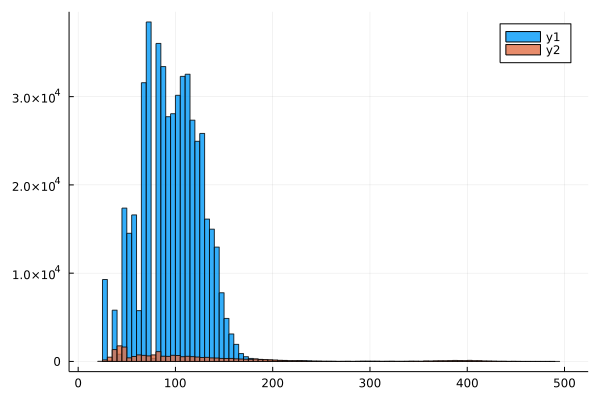

In [12]:
histogram(collect(skipmissing(filter(x->x.training>0.5,xold).QUAL_Vardict)),bins=100,alpha=0.8)
histogram!(collect(skipmissing(filter(x->x.training<0.5,xold).QUAL_Vardict)),bins=100,alpha=0.8)

In [39]:
# showtable(sample_key2[findall(x->x,[i==true for i in yold]),:]);

In [40]:
for j in 1:ncol(xold), i in 1:nrow(xold)
    if !ismissing(xold[i,j]) && (isnan(xold[i,j]) || isinf(xold[i,j]) )
        xold[i,j] = missing
    end
end

In [41]:
coldrop = [] # ["gt_AF_Vardict","AltFwd_Vardict","RefFwd_Vardict","AltRev_Vardict","RefRev_Vardict",
#     "gt_AD_ref_Vardict","gt_AD_alt_Vardict"]
for i in names(xold)
    if i == "col1" || i=="training"
        continue
    end
    if sum(ismissing.(xold[:,i])) / nrow(xold) > 0.6 
        push!(coldrop,i)
        println(i)
    end
    
    if length(unique(xold[:,i])) < 2 || occursin("Pindel",i) || occursin("Lofreq",i) || occursin("Mutect",i) # || occursin("ALT",i) || occursin("REF",i)
        push!(coldrop,i)
#         println(i)
    end 
end
unique!(coldrop);


gt_AD_alt_Pindel
gt_AD_ref_Pindel
gt_AF_Pindel
pon_pvalue_Pindel
total_greater_than_min_alt_count_Pindel
dust_score_Pindel
dust_score_3_Pindel
dust_score_5_Pindel
dust_score_10_Pindel
total_Pindel
total_greater_than_min_alt_count_Vardict
gt_AD_alt_Lofreq
total_greater_than_min_alt_count_Lofreq
GERMQ_Mutect
MPOS_Mutect
ROQ_Mutect
TLOD_Mutect
gt_AD_alt_Mutect
gt_AD_ref_Mutect
gt_AF_Mutect
RefFwd_Mutect
RefRev_Mutect
AltFwd_Mutect
AltRev_Mutect
pon_pvalue_Mutect
total_greater_than_min_alt_count_Mutect
dust_score_Mutect
dust_score_3_Mutect
dust_score_5_Mutect
dust_score_10_Mutect
total_Mutect
fwdbias_Mutect
revbias_Mutect
MBQ_Mutect_1
MBQ_Mutect_2
MFRL_Mutect_1
MFRL_Mutect_2
MMQ_Mutect_1
MMQ_Mutect_2


In [42]:
select!(xold, Not(coldrop));
println(sum([i==true for i in yold]))
# println(nrow(xold))
# dropmissing!(xold)
# println(nrow(xold))

println(size(yold))
println(length(sample_key2))
println()
yold = yold[xold.col1]
# println(xold[findall(x->x,[i==true for i in yold]),"col1"])
# println(xold[findall(x->!x,[i==true for i in yold]),"col1"])
sample_key2 = sample_key2[xold.col1]
select!(xold,Not("col1"));

println(size(xold))
println(size(yold))
println(length(sample_key2))
println(sum([i==true for i in yold]))

226
(1523404,)
1523404

(502855, 61)
(502855,)
502855
119


In [43]:
# istrain=0
# for i in 1:nrow(xold)
#     if sum(ismissing.(Vector(xold[i,:]))) > 0
# #         if xold[i,:training] > 0.5
# #             istrain += 1
# #         end
#         println(sample_key[i]," ",i)
#     end
# end
# println(istrain)

In [44]:
# showtable(xold[60:65,:])

In [45]:
# for col in names(xold)
#     println(col,"  ",1-sum(ismissing.(xold[:,col]))/nrow(xold) )
# end

In [46]:
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# filter(x->x.training>0.5 && x.real && (ismissing(x.MPOS_Mutect) || x.MPOS_Mutect < 30),xold)[:,["MPOS_Mutect","sample_key","real"]]

In [47]:
# namd=names(xsnv)[13] # 2,6,8,9,13
# namd="MBQ_Mutect_1"
# namd="MPOS_Mutect"
# xold.sample_key=sample_key
# xold.real=[i==true for i in yold]
# print(namd)
# histogram(collect(skipmissing(filter(x->x.training>0.5 && x.real,xold)[:,namd])),legend=true,label="TT",alpha=0.3,bins=10)
# histogram!(collect(skipmissing(filter(x->x.training<0.5 && x.real,xold)[:,namd])),label="BMT",alpha=0.3,bins=10)



In [48]:
# ysnv[[9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44]];

In [49]:
# ysnv[[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16]];

In [124]:
xsnv = copy(xold);
ysnv = copy(yold);



# train2 = findall(x->x,[i>0.5 for i in xsnv.training])
# test2 = findall(x->x,[i<0.5 for i in xsnv.training])

# train2 = [9, 12, 13, 14, 21, 24, 25, 26, 40, 41, 42, 44,
# 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15,16
# ]

# test2=setdiff(collect(1:length(ysnv)),train2)

train2, test2 = partition(eachindex(ysnv), 0.5, stratify=ysnv,  shuffle=true, rng=12344);

select!(xsnv,Not("training"));

println(length(train2))
println(length(test2))

251428
251427


In [125]:
stnd = fit_standardizer(xsnv[train2,:])
transform_standardizer!(xsnv,stnd);

In [126]:
# showtable(xsnv[1:10,:])

In [127]:
sum(ismissing.(Matrix(xsnv)))

418906

In [128]:
stmach = machine(MissingImputator(K=3),xsnv[train2,:]) 
@time sttran = fit!(stmach,verbosity=1)

┌ Info: Training Machine{MissingImputator,…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403


109.490581 seconds (660.29 M allocations: 97.929 GiB, 15.41% gc time)


Machine{MissingImputator,…} trained 1 time; caches data
  args: 
    1:	Source @041 ⏎ `Table{Union{AbstractVector{Union{Missing, ScientificTypesBase.Continuous}}, AbstractVector{ScientificTypesBase.Continuous}}}`


In [129]:
tt = MLJ.transform(sttran,xsnv);
for i in 1:ncol(xsnv)
    xsnv[:,i] = tt[i]
end

In [130]:
disallowmissing!(xsnv);

In [131]:
sample_key = copy(sample_key2)
train = copy(train2)
test = copy(test2)
x = copy(xsnv);
y = copy(ysnv);

In [132]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(251428, 60) 60
(251427, 60) 59
(251428,)
(502855,)


In [133]:
x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"under",0.0);
x,y,train,test,sample_key = sampler(x,y,train,test,sample_key,"over",0.01);

ratio: 0.00023869386715890648
number of new: 2454


In [134]:
y = coerce(copy(y),OrderedFactor);

In [135]:
println(size(x[train,:])," ",sum([i==true for i in y[train]] ) )
println(size(x[test,:])," ",sum([i==true for i in y[test]] ) )
println(size(y[train]))
println(size(sample_key))

(253882, 60) 2514
(251427, 60) 59
(253882,)
(505309,)


# MLJ Models

In [136]:
# select!(x,Not([]));

In [137]:

r = [
    range(EvoTreeClassifier(), :max_depth, lower=1,upper=7),
    range(EvoTreeClassifier(), :η, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :γ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :λ, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :α, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :min_weight, lower=0.0,upper=1.0),
    range(EvoTreeClassifier(), :nrounds, lower=1,upper=10),
    range(EvoTreeClassifier(), :nbins, lower=4, upper=128),
    
    
#     range(LogisticClassifier(), :lambda, lower=0.0,upper=1.0),
#     range(LogisticClassifier(), :gamma, lower=0.0,upper=1.0),
    
#     range(SVC(), :degree, lower=1,upper=4),
#     range(SVC(), :gamma, lower=0.0,upper=1.0),    
]

8-element Vector{MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T}:
 NumericRange(1 ≤ max_depth ≤ 7; origin=4.0, unit=3.0)
 NumericRange(0.0 ≤ η ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ γ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ λ ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ α ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(0.0 ≤ min_weight ≤ 1.0; origin=0.5, unit=0.5)
 NumericRange(1 ≤ nrounds ≤ 10; origin=5.5, unit=4.5)
 NumericRange(4 ≤ nbins ≤ 128; origin=66.0, unit=62.0)

In [138]:
self_tune = TunedModel(
#     model=LogisticClassifier(penalty=:l1),
#     model=SVC(),
    model=EvoTreeClassifier(),
    resampling=StratifiedCV(nfolds=5, rng=123),

    tuning=LatinHypercube(),  #     tuning=Grid(resolution=2), 
    range = r,
    n=20,
    operation=predict_mode, # use for probabalistic 
    measure = fnr,  # use for deterministic or with predict_mode for probab 
#     measure = brier_loss # use for probabalistic 
    acceleration=CPUThreads(),
)

machbest = machine(
    self_tune,
    x[train,:],y[train])
fit!(machbest,verbosity=1 )
# evaluate!(machbest,verbosity=2,resampling=StratifiedCV(nfolds=5, rng=123) )

# machbest=machine(
#     NeuralNetworkClassifier(builder=MLJFlux.Short(n_hidden=0),epochs=2),
#     x[train,inputvars],y[train])

# fit!(machbest,verbosity=1 )

┌ Info: Training Machine{ProbabilisticTunedModel{LatinHypercube,…},…}.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/machines.jl:403
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /Users/alexpanchot/.julia/packages/MLJTuning/efiDR/src/tuned_models.jl:685
Evaluating over 20 metamodels: 100%[=========================] Time: 0:03:21


Machine{ProbabilisticTunedModel{LatinHypercube,…},…} trained 1 time; caches data
  args: 
    1:	Source @358 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @025 ⏎ `AbstractVector{OrderedFactor{2}}`


In [139]:
# fitted_params(machbest).best_fitted_params[1]

In [167]:
fitted_params(machbest)[1]

EvoTreeClassifier(
    loss = EvoTrees.Softmax(),
    nrounds = 3,
    λ = 0.15789473684210525,
    γ = 0.47368421052631576,
    η = 0.8947368421052632,
    max_depth = 6,
    min_weight = 0.8421052631578947,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 95,
    α = 0.6842105263157895,
    metric = :mlogloss,
    rng = MersenneTwister(123, (0, 3809604, 3808602, 708)),
    device = "cpu")

In [141]:
yhat=MLJ.predict_mode(machbest, x[test,:]); # probab
# yhat=MLJ.predict(machbest, x[test,:]); # determ

In [168]:
ConfusionMatrix()(yhat,y[test])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │   251237    │     23      │
├─────────────┼─────────────┼─────────────┤
│    true     │     131     │     36      │
└─────────────┴─────────────┴─────────────┘


In [143]:
# density(x.QUAL_Vardict[train])
# density!(x.QUAL_Vardict[test])

In [144]:
report(machbest).best_report.feature_importances # Evo Tree
# fitted_params(machbest).best_fitted_params.coefs[sortperm([i[2] for i in fitted_params(machbest).best_fitted_params.coefs])]



60-element Vector{Pair{String, Float64}}:
        "QUAL_Vardict" => 0.4360443052875691
       "PMEAN_Vardict" => 0.18501539488169697
  "pon_pvalue_Vardict" => 0.1459565261332648
          "NM_Vardict" => 0.0427218981784138
      "RefFwd_Vardict" => 0.02994773015832944
              "FPpass" => 0.026736693106247735
     "revbias_Vardict" => 0.024772508521177624
      "AltFwd_Vardict" => 0.017834213865789924
      "RefRev_Vardict" => 0.014629974567615521
       "ADJAF_Vardict" => 0.014319267961857455
         "SBF_Vardict" => 0.011410915938578473
    "ODDRATIO_Vardict" => 0.011219761024155273
   "gt_AD_ref_Vardict" => 0.010971924911968692
                       ⋮
        "SYMBOL_CHEK2" => 0.0
        "SYMBOL_SRSF2" => 0.0
             "alt_len" => 0.0
 "VARIANT_CLASS_indel" => 0.0
  "dust_score_Vardict" => 0.0
        "SYMBOL_PPM1D" => 0.0
      "SHIFT3_Vardict" => 0.0
 "FILTER_Vardict_Bias" => 0.0
        "SYMBOL_SF3B1" => 0.0
             "ref_len" => 0.0
   "FILTER_Vardict_p8" => 0.0


In [146]:
aa = DataFrame(prob = MLJ.predict(machbest, x[test,:]),sample_key=sample_key[test], vaf = untransform_standardizer(x,stnd)[test,"gt_AF_Vardict"],  x1=yhat,x2=y[test])  
filter!(x-> x.x1==false && x.x2==true && x.vaf>0.001,aa)
showtable(select(aa, ["sample_key","prob","vaf"]))

# CSV.write("bmtreals3.csv",leftjoin(CSV.read("bmtreals2.csv",DataFrame),aatemp,on=:sample_key))
# aatp=filter(x-> x.x1==true && x.x2==true ,aa)

# # CSV.write("bmtreals2.csv",leftjoin(CSV.read("bmtreals1.csv",DataFrame),
# #         DataFrame(sample_key=aafn.sample_key, vardictFN = [1 for i in nrow(aafn)])
# #         ,on=:sample_key))
# # CSV.write("bmtreals2.csv",leftjoin(CSV.read("bmtreals2.csv",DataFrame),
# #         DataFrame(sample_key=aatp.sample_key, vardictTP = [1 for i in nrow(aatp)])
# #         ,on=:sample_key))



WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol, Any}(:style => Dict("height" => "0", "padding" => "0", "background-color" => "#F5F7F7", "color" => "#1c1f20", "font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol, Any}(:id => "grid-b6ae9d4e", :className => "ag-theme-balham", :style => Dict("height" => "274px", "width" => "100%")))], Dict{Symbol, Any}()), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing), "onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/src/rowNumberRenderer.js"), WebIO.Asset("js", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.js"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-light.css"), WebIO.Asset("css", nothing, "/Users/alexpanchot/.julia/packages/TableView/CaHPi/deps/ag-grid-25.2.0/ag-grid-dark.css")], Dict{Any, Any}(), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000011f12b530, Task (runnable) @0x000000011f12b530), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"859424308584183350\",\"id\":\"1654241952454836904\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"rowSelection\":\"multiple\",\"multiSortKey\":\"ctrl\",\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":true,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":true,\"editable\":false,\"headerTooltip\":\"String\",\"field\":\"sample_key\",\"headerName\":\"sample_key\",\"sortable\":true,\"type\":null,\"resizable\":true},{\"filter\":true,\"editable\":false,\"headerTooltip\":\"UnivariateFinite{Multiclass{2}, Bool, UInt8, Float64}\",\"field\":\"prob\",\"headerName\":\"prob\",\"sortable\":true,\"type\":null,\"resizable\":true},{\"filter\":\"agNumberColumnFilter\",\"editable\":false,\"headerTooltip\":\"Float32\",\"field\":\"vaf\",\"headerName\":\"vaf\",\"sortable\":true,\"type\":\"numericColumn\",\"resizable\":true}],\"onCellDoubleClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellDoubleClicked\",\"scope\":\"859424308584183350\",\"id\":\"17181329512534973986\",\"type\":\"observable\"},x)}),\"onRowClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onRowClicked\",\"scope\":\"859424308584183350\",\"id\":\"109370182043800783\",\"type\":\"observable\"},x)}),\"onCellKeyDown\":(function (ev){var x={}; (ev.r

In [150]:
# atemp=CSV.read("bmtreals2.csv",DataFrame)
# coldrop = []
# for i in names(atemp)
    
#     if occursin("Pindel",i) || occursin("Lofreq",i) || occursin("Varscan",i) # || occursin("ALT",i) || occursin("REF",i)
#         push!(coldrop,i)
# #         println(i)
#     end 
# end
# unique!(coldrop)
# CSV.write("bmtreals3.csv",select(atemp,Not(coldrop)) )

# Bayes

In [151]:
xb = copy(x);
yb = [i==true for i in copy(y)];

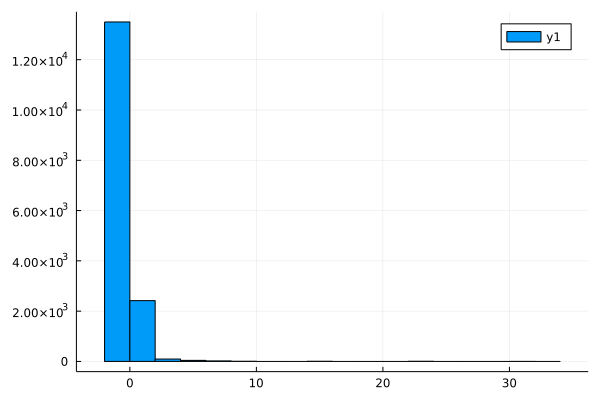

In [152]:
histogram(xb.ODDRATIO_Vardict,bins=20)

In [153]:
# ? Gamma()

In [162]:
# @model function logistic_regression(x, y, n)
#     intercept ~ Normal(0, 1)
    
# #     p1 ~ Normal()
# #     p2 ~ Beta()
# #     p3 ~ Beta()
# #     p4 ~ Beta()
# #     p5 ~ Categorical(80)
# #     p6 ~ Normal()
# #     p7 ~ Categorical(5)
# #     p8 ~ Normal()
# #     p9 ~ Normal()
# #     p10 ~ Categorical(25)
# #     p11 ~ Categorical(5)
# #     p12 ~ Categorical(3)
    
#     p1 ~ Normal()
#     p2 ~ Gamma()
#     p3 ~ Gamma()
#     p4 ~ Normal()
#     p5 ~ Beta()
    
#     for i = 1:n
# #         v = logistic(intercept + sum(params .* Vector(x[i, :]) ) )
#         v = logistic(intercept + p1 * x[i, 1] + p2 * x[i, 2] + p3 * x[i, 3] + p4 * x[i, 4] + p5 * x[i, 5]
#         )
#         y[i] ~ Bernoulli(v)
#     end
# end;

@model function logreg(X,  y; predictors=size(X, 2))
    #priors
    X = Matrix(X)
    y = convert.(Float32,y)
    α ~ Normal(0, 2.5)
    β ~ filldist(TDist(3), predictors)

    #likelihood
#     for i in 1:predictors
#         y[i] ~ BernoulliLogit(α + LinearAlgebra.dot(X[i,:], β) ) # arraydist( LazyArray(@~ BernoulliLogit.(α .+ X * β) ) )
#     end
    y ~ arraydist(LazyArray(Base.broadcasted(x -> BernoulliLogit(x), α .+ X * β) ))
end;


In [196]:
d = train #vcat(train[findall(x->x,yb[train])],train[1:1425])
inputvars = ["gt_AF_Vardict","ODDRATIO_Vardict","dust_score_Vardict","PMEAN_Vardict",
    "pon_pvalue_Vardict","SBF_Vardict","RefRev_Vardict","QUAL_Vardict"];


In [197]:
sum(.~ yb[d])

1602

In [198]:
sum(yb[d])

16

In [199]:
# findall(x->x,yb[train])

In [200]:
# train[1:385]

In [201]:

# gmm_sampler = Gibbs(PG(100,:p5,:p7,:p10,:p11,:p12), HMC(0.05, 100, :intercept, :p1,:p2,:p3,:p4,:p6,:p8,:p9))

# Sample using HMC.
m = logreg(xb[d,inputvars],yb[d])

chain = sample(m, NUTS(), MCMCThreads(), 5000, 3, progress=true)
# chain = sample(m, gmm_sampler, MCMCThreads(), 100, 5, progress=true)
# chain = sample(m, NUTS(50,0.65), MCMCThreads(), 100, 2, progress=true)
# describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (5000×21×3 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 3
Samples per chain = 5000
Wall duration     = 54.02 seconds
Compute duration  = 160.18 seconds
parameters        = α, β[1], β[2], β[3], β[4], β[5], β[6], β[7], β[8]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           α   -8.1943    0.9158     0.0075    0.0120    6529.8150    0.9999   ⋯
        β[1]    0.0891    0.1935     0.0016    0.0020   10980.9967    1.0005   ⋯
        β[2]   -4.7358    2.1274     0.0174    0.0278    7185.4829    0.9999   ⋯
        β[3]   -0.6837    0.2583     0.0021    0.0031    8148.8092    0.9999   ⋯
        β[4]    1.336

In [202]:
plot(chain)

In [203]:
function prediction_turing(x, chain)
    # Pull the means from each parameter's sampled values in the chain.


    # Retrieve the number of rows.
    n = size(x,1)

    # Generate a vector to store our predictions.
    v = fill(mean(chain["α"]), n)

    # Calculate the logistic function for each element in the test set.
    

    for beta_j in 1:size(x,2)
        mm = mean(chain["β[$(beta_j)]"])
#         mm = mode(round.(chain["β[$(beta_j)]"],digits=4))
        if abs(mm) > 0.00001
            for i in 1:n
                v[i] += mm * x[i,beta_j] 
            end
        end
    end
        

    v = logistic.(v)
    return v
end;

In [204]:
ypred = prediction_turing(xb[test,inputvars],chain);

In [211]:
yhat2 = [i>.01 ? true : false for i in ypred];

In [212]:
MLJ.ConfusionMatrix()(yhat2,yb[test])

┌ Warning: The classes are un-ordered,
│ using: negative='false' and positive='true'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/HZmTU/src/measures/confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │    13857    │      2      │
├─────────────┼─────────────┼─────────────┤
│    true     │     562     │     68      │
└─────────────┴─────────────┴─────────────┘


In [189]:
# [print(i," ") for i in train]

In [190]:
asd=yhat2 .< yb[test];

In [191]:
sum(yb[test])

70

In [192]:
yb[test[asd]];

In [193]:
sample_key[test][asd]

37-element Vector{String}:
 "272341_1_100 4:106158216 G>A"
 "736399_1_100 4:106196951 A>G"
 "887041_1_100 20:31022441 A>AG"
 "272341_1_100 4:106180838 G>T"
 "887041_1_5000 20:31022441 A>AG"
 "736399_1_100 4:106156187 C>T"
 "761809_1_100 2:25536827 G>A"
 "218281_1_100 4:106193940 A>T"
 "761809_1_10 2:25464501 GT>G"
 "887041_1_1000 20:31022441 A>AG"
 "272341_1_1000 4:106155751 G>A"
 "272341_1_1000 4:106158216 G>A"
 "761809_1_10 2:25457242 C>T"
 ⋮
 "809382_1_100 4:106157569 A>T"
 "272341_1_1000 20:31022441 A>AG"
 "272341_1_100 20:31022441 A>AG"
 "887041_1_1000 4:106196951 A>G"
 "887041_1_100 17:7579472 G>C"
 "809382_1_100 4:106157983 C>T"
 "272341_1_5000 20:31022441 A>AG"
 "887041_1_100 2:25467083 G>A"
 "218281_1_100 2:25457243 G>A"
 "887041_1_100 2:198265526 A>G"
 "218281_1_100 17:7578534 C>G"
 "887041_1_1000 2:198265526 A>G"

In [186]:
# sample_key[train][yb[train]]

# Flux

In [333]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, logitcrossentropy, throttle, @epochs
using Base.Iterators: repeated
using Parameters: @with_kw


In [376]:
@with_kw mutable struct Args
    η::Float64 = 3e-4       # learning rate
    batchsize::Int = 4   # batch size
    epochs::Int = 2       # number of epochs
    device::Function = cpu  # set as gpu, if gpu available
end

Args

In [377]:
xb = copy(x);
yb = [i==true for i in copy(y)];

In [378]:
function getdata(args)
    # Batching
    train_data = DataLoader( (Matrix(Matrix(xb[train,inputvars])'), float.(yb[train])), batchsize=args.batchsize, shuffle=true)
    test_data = DataLoader( (Matrix(Matrix(xb[test,inputvars])'), float.(yb[test])), batchsize=args.batchsize)

    return train_data, test_data
end

getdata (generic function with 1 method)

In [379]:
function build_model(;)
    return Chain(
 	    Dense(8, 32, relu),
            Dense(32, 2))
end

build_model (generic function with 1 method)

In [380]:
function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader
        l += logitcrossentropy(model(x), y)
    end
    l/length(dataloader)
end

loss_all (generic function with 1 method)

In [391]:
args = Args()

Args
  η: Float64 0.0003
  batchsize: Int64 4
  epochs: Int64 2
  device: cpu (function of type typeof(cpu))


In [392]:
m = args.device(m)
    loss(x,y) = logitcrossentropy(m(x), y)

loss (generic function with 1 method)

In [386]:
function trainm(; kws...)
    # Initializing Model parameters 
    args = Args(; kws...)

    # Load Data
    train_data,test_data = getdata(args)

    # Construct model
    m = build_model()
    train_data = args.device.(train_data)
    test_data = args.device.(test_data)
    m = args.device(m)
    loss(x,y) = logitcrossentropy(m(x), y)
    
    ## Training
#     evalcb = () -> @show(loss_all(train_data, m))
    opt = ADAM(args.η)
		
    @epochs args.epochs Flux.train!(loss, Flux.params(m), train_data, opt,
#         cb = evalcb
    )

    @show accuracy(train_data, m)

    @show accuracy(test_data, m)
end

trainm (generic function with 1 method)

In [387]:
trainm()

┌ Info: Epoch 1
└ @ Main /Users/alexpanchot/.julia/packages/Flux/ZnXxS/src/optimise/train.jl:138
┌ Warning: Size mismatch in loss function! In future this will be an error. In Flux <= 0.12 broadcasting accepts this, but may not give sensible results
│   summary(ŷ) = 2×4 Matrix{Float32}
│   summary(y) = 4-element Vector{Float64}
└ @ Flux.Losses /Users/alexpanchot/.julia/packages/Flux/ZnXxS/src/losses/utils.jl:30


LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 4 and 2")

# Flux & Turing

In [214]:
Turing.setadbackend(:zygote)

:zygote

In [300]:
# Turn a vector into a set of weights and biases.
function unpack(nn_params::AbstractVector)
    W₁ = reshape(nn_params[1:6], 3, 2);   
    b₁ = nn_params[7:9]
    
    W₂ = reshape(nn_params[10:15], 2, 3); 
    b₂ = nn_params[16:17]
    
    Wₒ = reshape(nn_params[18:19], 1, 2); 
    bₒ = nn_params[20:20]
    return W₁, b₁, W₂, b₂, Wₒ, bₒ
end

# Construct a neural network using Flux and return a predicted value.
function nn_forward(xs, nn_params::AbstractVector)
    W₁, b₁, W₂, b₂, Wₒ, bₒ = unpack(nn_params)
    
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, b₂, tanh),
               Dense(Wₒ, bₒ, σ))
    return nn(xs)
end;

In [328]:
# Create a regularization term and a Gaussain prior variance term.
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabilistic model.
@model function bayes_nn(xs, ts)
#     println(size(xs))
    xs = Matrix(xs')
    ts = convert.(Float32,ts)
    # Create the weight and bias vector.
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for the inputs given the weights
    # and biases in theta.
#     println(size(xs))
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction.
#     for i = 1:length(ts)
#         ts[i] ~ Bernoulli(preds[i])
#     end
    ts ~ arraydist(LazyArray(Base.broadcasted(x -> Bernoulli(x), preds) ))
end;

In [329]:
xs = Matrix(xb[train,["SBF_Vardict","QUAL_Vardict"]]) ;

In [330]:
ts = yb[train] ;

In [331]:
# Perform inference.
N = 50
ch = sample(bayes_nn(xs, ts), HMC(0.01, 4), N);

LoadError: MethodError: no method matching loglikelihood(::DistributionsAD.MatrixOfUnivariate{Discrete, Bernoulli{Float64}, BroadcastMatrix{Bernoulli{Float64}, var"#206#208", Tuple{Matrix{Float64}}}}, ::Vector{Float32})
[0mClosest candidates are:
[0m  loglikelihood([91m::EllipticalSliceSampling.ESSModel[39m, ::Any) at /Users/alexpanchot/.julia/packages/EllipticalSliceSampling/5pcNQ/src/model.jl:23
[0m  loglikelihood(::MatrixDistribution{S} where S<:ValueSupport, [91m::AbstractArray{var"#s473", 3} where var"#s473"<:Real[39m) at /Users/alexpanchot/.julia/packages/Distributions/1313k/src/matrixvariates.jl:228
[0m  loglikelihood([91m::StatisticalModel[39m, ::Any) at /Users/alexpanchot/.julia/packages/StatsBase/DWW4r/src/statmodels.jl:95
[0m  ...

In [ ]:
# Extract all weight and bias parameters.
theta = MCMCChains.group(ch, :nn_params).value;

In [306]:
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

80-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [319]:
Matrix(xs')

2×1618 Matrix{Float32}:
 -0.111084   -0.000642497   1.73058  …  -1.14771  -1.0438   -0.804558
  0.0937365  -0.309782     -1.30513      6.30793   9.69748   0.900774